# ロジスティック回帰モデル

Pythonの機械学習用ライブラリ`scikit-learn`を使って，ロジスティック回帰モデルを使って簡単な分類問題にチャレンジしてみましょう.

---

### 0.ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd

import sklearn

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=4)

In [2]:
print("numpy :", np.__version__)
print("pandas :", pd.__version__)
print("sklearn :", sklearn.__version__)
print("seaborn :", sns.__version__)
print("matplotlib :", matplotlib.__version__)

numpy : 1.16.1
pandas : 0.24.2
sklearn : 0.20.2
seaborn : 0.9.0
matplotlib : 3.0.2


### 1. データの読込・整形

`sklearn.datasets`からIrisデータセットを読み込みましょう．

In [3]:
# make data samples
from sklearn.datasets import load_iris
iris = load_iris()

次に，pandas DataFrame()クラスのインスタンスとして，変数`df_feature`, `df_target`, `df`を定義します．

参考: [pandas.DataFrame — pandas 1.0.1 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

In [4]:
df_feature = pd.DataFrame(iris.data, columns=iris.feature_names)
df_target = pd.DataFrame(iris.target, columns=["target"])
df_target.loc[df_target['target'] == 0, 'target_name'] = "setosa"
df_target.loc[df_target['target'] == 1, 'target_name'] = "versicolor"
df_target.loc[df_target['target'] == 2, 'target_name'] = "virginica"
df = pd.concat([df_target, df_feature], axis=1)

df.head(10)

,target,target_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,setosa,5.1,3.5,1.4,0.2
1,0,setosa,4.9,3.0,1.4,0.2
2,0,setosa,4.7,3.2,1.3,0.2
3,0,setosa,4.6,3.1,1.5,0.2
4,0,setosa,5.0,3.6,1.4,0.2
5,0,setosa,5.4,3.9,1.7,0.4
6,0,setosa,4.6,3.4,1.4,0.3
7,0,setosa,5.0,3.4,1.5,0.2
8,0,setosa,4.4,2.9,1.4,0.2
9,0,setosa,4.9,3.1,1.5,0.1


データの要約統計量(サンプル数, 平均, 標準偏差, 四分位数, 中央値, 最小値, 最大値など)をみましょう．

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


データの共分散行列を描画します．<br>
対角成分は自分との共分散(相関)を表すため常に1.0となります．

In [6]:
df.corr()

,target,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,1.000000,0.782561,-0.426658,0.949035,0.956547
sepal length (cm),0.782561,1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.426658,-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.949035,0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.956547,0.817941,-0.366126,0.962865,1.000000


seabornを使って，共分散行列を可視化してみましょう．

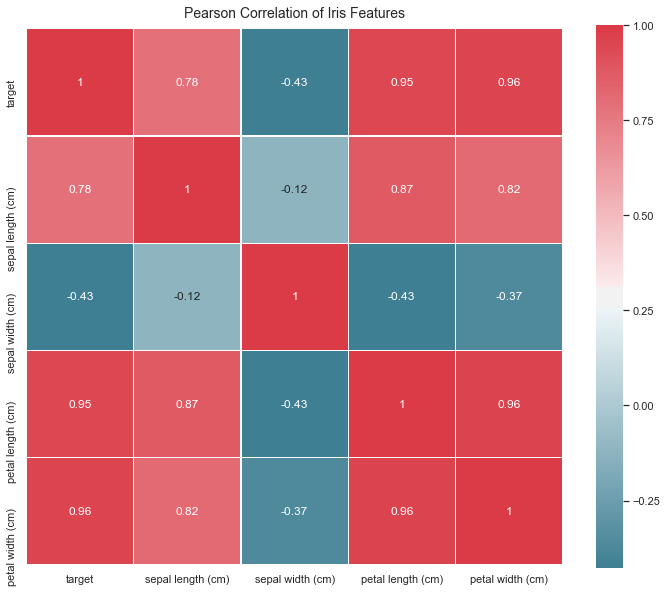

In [7]:
# Correlation matrix

sns.set()
cols = ['target', 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] # プロットしたい特徴量

plt.figure(figsize=(12,10))
plt.title('Pearson Correlation of Iris Features', y=1.01, fontsize=14)
sns.heatmap(df[cols].astype(float).corr(), 
            linewidths=0.1,
            vmax=1.0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True,
            linecolor='white', 
            annot=True)

データの散布図行列を描画します．<br>
相関が大きい説明変数のペアについては, 多重共線性を考えるべきです.

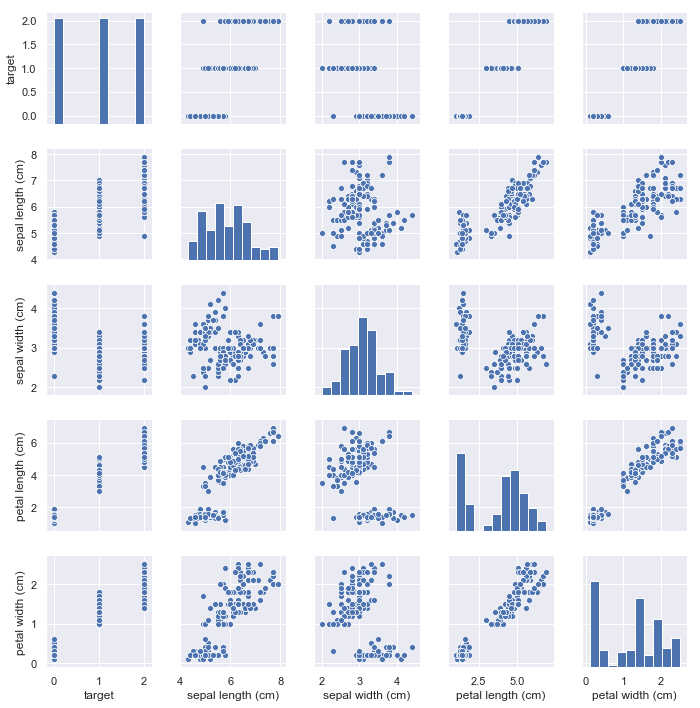

In [8]:
# pairplot 
sns.set()
sns.pairplot(df, diag_kind='hist', height=2.0)
plt.show()

分類用のデータセットには，各データに対応するクラスラベルが与えられています．<br>
上の散布図行列の各点を所属する3つのクラスに応じて色分けしてみましょう．

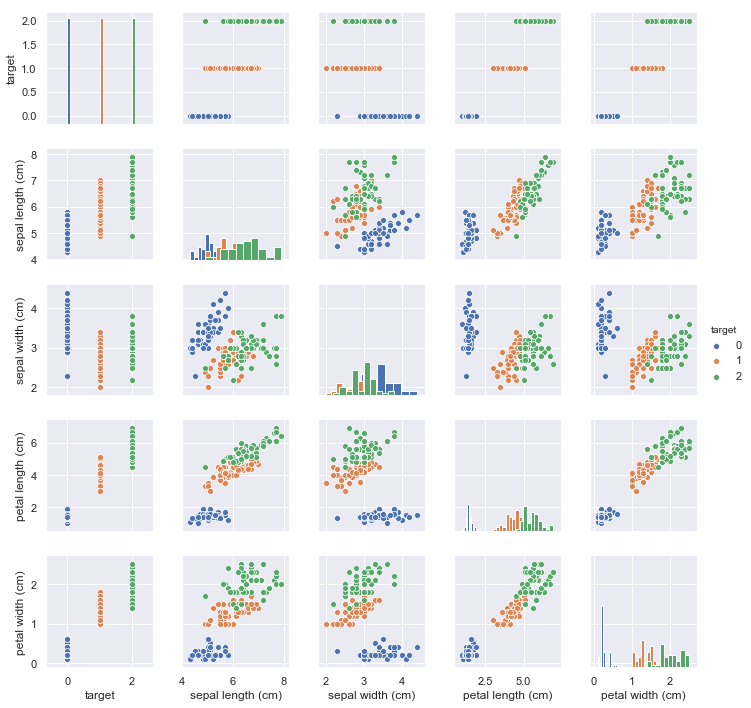

In [9]:
sns.set()
sns.pairplot(df, hue='target', diag_kind='hist', height=2.0)
plt.show()

### 2. データの分割

変数`iris`から，説明変数と目的変数に相当するデータをそれぞれ取り出し，numpy.ndarray()クラスの変数`X`, `y`へ格納します．

In [10]:
X = iris.data
y = iris.target

全データをtrainデータとtestデータに分割します．
すなわち，変数`X`を`X_train`と`X_test`に，
変数`y`を`y_train`と`y_test`に分けます．

In [11]:
# split data by Hold-out-method
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

`print()`で配列の形状を確認してみましょう．

In [12]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (120, 4)
y_train:  (120,)
X_test:  (30, 4)
y_test:  (30,)


- X_train: 4次元データが120コ格納されている．
- y_train: 1次元データが120コ格納されている．
- X_test: 4次元データが30コ格納されている．
- y_test: 1次元データが30コ格納されている．

### 3. モデルの作成

In [13]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0, 
                            solver='lbfgs', 
                            multi_class='auto')

### 4. モデルへデータを適合させる

In [14]:
# fit
clf_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### モデルの評価

In [15]:
# predictions
y_train_pred = clf_lr.predict(X_train)
y_test_pred = clf_lr.predict(X_test)

In [16]:
# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy (train)  : {:>.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy (test)   : {:>.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy (train)  : 0.9667
Accuracy (test)   : 1.0000


In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(y_train, y_train_pred)
cmat_test = confusion_matrix(y_test, y_test_pred)

In [18]:
def print_confusion_matrix(confusion_matrix, class_names, plt_title='Confusion matrix: ', cmap='BuGn', figsize = (6.25, 5), fontsize=10):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(plt_title, fontsize=fontsize*1.25)
    plt.show()

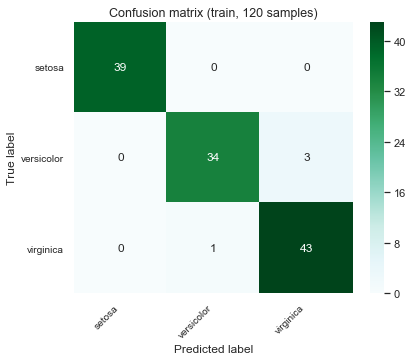

In [19]:
print_confusion_matrix(cmat_train, 
                       iris.target_names, 
                       plt_title='Confusion matrix (train, 120 samples)')

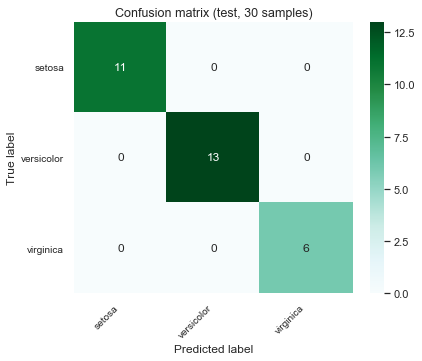

In [20]:
print_confusion_matrix(cmat_test, 
                       iris.target_names, 
                       plt_title='Confusion matrix (test, 30 samples)')